## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
import unidecode
import dateutil
import json

## Configuration

In [2]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [3]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Variables and constants

In [4]:
limit_frequency = 1000

In [5]:
accepted_quantile = 1

In [6]:
today = datetime.datetime.now()

In [7]:
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2021,4,1)

In [8]:
last = start_date
quarters_list = [last]
q = 0
while last <= end_date:
    if (q != (last.month-1)//3):
        q = (last.month-1)//3
        quarters_list.append(last)
    last = last + dateutil.relativedelta.relativedelta(months=+1)

In [9]:
quarters = {}
for i, val in enumerate(quarters_list):
    if i+1 < len(quarters_list):
        quarters['Q{}{}'.format((val.month-1)//3+1,val.year)] = {
            'start': val.date(),
            'end': quarters_list[i+1].date() if quarters_list[i+1] < today else today.date()
        }
quarters

{'Q12020': {'start': datetime.date(2020, 1, 1),
  'end': datetime.date(2020, 4, 1)},
 'Q22020': {'start': datetime.date(2020, 4, 1),
  'end': datetime.date(2020, 7, 1)},
 'Q32020': {'start': datetime.date(2020, 7, 1),
  'end': datetime.date(2020, 10, 1)},
 'Q42020': {'start': datetime.date(2020, 10, 1),
  'end': datetime.date(2021, 1, 1)},
 'Q12021': {'start': datetime.date(2021, 1, 1),
  'end': datetime.date(2021, 3, 15)}}

In [10]:
rf_segment = {
    '20': 'fidèles',
    '02':'occasionnels',
    '12':'occasionnels',
    '22':'occasionnels',
    '00':'reconnus',
    '01':'reconnus',
    '10':'reconnus',
    '11':'reconnus',
    '21':'reconnus'
}

In [11]:
segments = {}
for key, value in rf_segment.items():
    if not value in segments:
        segments[value] = {'name': unidecode.unidecode(value), 'values':[]}
    segments[value]['values'].append(key)
segments

{'fidèles': {'name': 'fideles', 'values': ['20']},
 'occasionnels': {'name': 'occasionnels', 'values': ['02', '12', '22']},
 'reconnus': {'name': 'reconnus', 'values': ['00', '01', '10', '11', '21']}}

In [12]:
segments['fidèles']['color'] = '#E6ACAC'
segments['occasionnels']['color'] = '#D4C4C4'
segments['reconnus']['color'] = '#28D1D1'
segments['outliers'] = {'color': '#555D9E'}

In [13]:
colors = {seg:value['color'] for seg, value in segments.items()}

## Initialization

In [14]:
quarter = 'Q12021'

In [15]:
segment = segments['fidèles']

## Utilitaires

In [16]:
def export_df(df, name, date=True):
    df.to_csv('output/{}{}.csv'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name), index=False, encoding='utf-8-sig')

In [17]:
def export_fig(plot, name, date=True):
    plot.savefig('images/{}{}.png'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name))

In [18]:
def set_group(df, row, col):
    for i, q in enumerate(range(0, 10, 2)):
        if row[col] <= df[col].quantile(q/10 + 0.2):
            return i+1

In [19]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

## Données

In [20]:
#df_users = pd.read_csv('output/assigned_baseline (1).csv')
#df_users = df_users[['profileId','AssignedGender','AssignedBirthDeceny']].rename(columns={'profileId':'actitoid', 'AssignedGender':'gender','AssignedBirthDeceny':'birth_deceny'})
#df_users['birth_deceny'] = df_users['birth_deceny'].apply(lambda x: datetime.datetime.now().year - int(x.split('-')[0]) if x == x else np.nan)
#df_gigya = pd.read_sql_query("""SELECT uid, actitoid FROM egos_gigya""", engine)
#df_users = df_users.merge(df_gigya, on='actitoid')
#df_users = df_users[['uid', 'gender', 'birth_deceny']]
#df_users = df_users[df_users['birth_deceny'] <= 85]
#export_df(df_users, 'users_socio_demo')

In [23]:
df_users = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/210128_users_socio_demo.csv')
df_users = df_users.rename(columns={'declared_deceny':'birth_deceny'})
df_users.head()

uid  birth_deceny gender
0  00013e4f4736435ab19025635319a6b9           NaN      f
1  00065798e9e646b5875cc662073380ab           NaN      f
2  000684717d72475eb174052f2e0fb72b          55.0      m
3  00078ff520344776a323c21eef35de89          15.0      m
4  00097bb19cc54349904b3ba360fcbbf6          35.0      f

In [24]:
df_users_assigned = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/210122_users_socio_demo.csv')
df_users_assigned.head()

uid gender  birth_deceny
0                   a134043377504694acc58aef9dc3a7cb      f          45.0
1  _guid_ybOVBUwdgbTzMejftu-KQ0f-iD_Ao1hG00YZzc4W...      m          75.0
2  _guid_a6PpdpPrtZUMwZ5cqDfP2_0GeYBgpYiLOyS_nj_R...      m          45.0
3  _guid_3xPIcg0OkYTG224SkHf3mpz-o1Mec9evU3b2XWP0...      m          15.0
4  _guid_yzSw6_RLbvtk2fWX903qTDrlezk6PJnHDgVeF36x...      m          35.0

### Users Recence
```sql
SELECT uid, MAX(date) as date
FROM egos_conso_audio_video_connected_user
WHERE media_type = context_media_type
  AND date >= '{}'
  AND date < '{}'
GROUP BY uid
```

In [25]:
#df_recency = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/{}_users_recency.csv'.format(quarter), parse_dates=['date'])
#df_recency = df_recency[~df_recency['date'].isna()]
#df_recency['recency'] = df_recency['date'].apply(lambda x: (quarters[quarter]['end'] - x.date()).days)
#df_recency.head()

uid       date  recency
0  00130b356b6c44ac91318262ab162b61 2021-03-14        1
1  001805678d184b1689901dc1eea5ad10 2021-03-09        6
2  00305b64b6f24f12be20149516c48260 2021-03-14        1
3  0036f52b70a34d11b64fff9a0d8822b0 2021-03-14        1
4  003fa68b239a4211a2ed4e6fd41a85f8 2021-03-11        4

### Users Frequency
```sql
SELECT uid, COUNT(date) AS frequency
FROM egos_conso_audio_video_connected_user
WHERE media_type = context_media_type
  AND date >= '{}'
  AND date < '{}'
GROUP BY uid
```

In [26]:
#df_frequency = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/{}_users_frequency.csv'.format(quarter))
#df_frequency.head()

uid  frequency
0  000ab8ad3ea1415e9d6b080f11e04200         75
1  0079bc7ff8cc4abdbd0bf555a94647a9         87
2  008dfb1b029f445cac74cd7e60c33969         26
3  00bccfbdfcf6415595686a3f8f07d4ae          7
4  00c0ab7d14474ded8ecaaa0613338bfb        132

### Users Days
```sql
SELECT uid, COUNT(DISTINCT DATE_PART('day', date)) AS days
FROM egos_conso_audio_video_connected_user
WHERE media_type = context_media_type
  AND date >= '{}'
  AND date < '{}'
GROUP BY uid
```

In [27]:
#df_days = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/{}_users_days.csv'.format(quarter))
#df_days.head()

uid  days
0  _guid_zRkHfdY1LXTWW5hVYFG7vDmG-jRuUpJL3vRjulf0...    28
1                   5184d46638cb4219b8bb7446ff71918a     4
2                   8220237a67f9430ca966362822d945ae    19
3                   5a98a9a0139b409a905347934531f51f     5
4  _guid_GlJY-hxqPSN0eHEB_FnGYPKJ7edgGje8PnmqwuzI...     4

---

In [28]:
#df = df_recency.merge(df_frequency, on='uid', how='inner')
#df = df.merge(df_days, on='uid', how='left')
#df.head()

uid       date  recency  frequency  days
0  00130b356b6c44ac91318262ab162b61 2021-03-14        1        236    31
1  001805678d184b1689901dc1eea5ad10 2021-03-09        6         39    17
2  00305b64b6f24f12be20149516c48260 2021-03-14        1         24    18
3  0036f52b70a34d11b64fff9a0d8822b0 2021-03-14        1        190    28
4  003fa68b239a4211a2ed4e6fd41a85f8 2021-03-11        4        207    31

In [29]:
#df = df[~df['recency'].isna()]
#df = df[~df['frequency'].isna()]
#export_df(df, '{}_users_rfv'.format(quarter), date=False)
#df.shape

(651224, 5)

In [30]:
df = pd.read_csv('/home/meili/Projects/data-access-app/scripts/output/{}_users_rfv.csv'.format(quarter))
df.head()

uid        date  recency  frequency  days
0  0072c93fcc4742a58aa1d15e803480b0  2021-01-03       26         18     3
1  009fc6f8613c4a29b40c40fa9ca6fbe3  2021-01-22        7          3     2
2  00d276777288420e91634626065a7f70  2021-01-19       10          4     2
3  00fe8b718af04a9d95a3c43b050f5f79  2021-01-28        1         56    14
4  0150f3f8b25e419cb676711ab596c2a0  2021-01-27        2         21    11

In [31]:
df['uid'].unique().shape

(395712,)

In [33]:
df_clustering = df[df['frequency']<=df['frequency'].quantile(accepted_quantile)]
df_clustering.head()

uid        date  recency  frequency  days
0  0072c93fcc4742a58aa1d15e803480b0  2021-01-03       26         18     3
1  009fc6f8613c4a29b40c40fa9ca6fbe3  2021-01-22        7          3     2
2  00d276777288420e91634626065a7f70  2021-01-19       10          4     2
3  00fe8b718af04a9d95a3c43b050f5f79  2021-01-28        1         56    14
4  0150f3f8b25e419cb676711ab596c2a0  2021-01-27        2         21    11

### Media available
```sql
SELECT labelstat, COUNT(uid) AS users FROM (( SELECT mp.labelstat, uid, date FROM media_objects mo INNER JOIN media_programs mp on mo.program_id = mp.id LEFT JOIN egos_conso_audio_video_connected_user conso ON mo.id = conso.media_id WHERE ((mo.live_from BETWEEN '2020-10-01' AND '2021-01-01' OR mo.live_until BETWEEN '2020-10-01' AND '2021-01-01') OR ('2020-10-01' BETWEEN mo.live_from AND mo.live_until OR '2021-01-01' BETWEEN mo.live_from AND mo.live_until)) ) UNION ALL (SELECT mep.labelstat, uid, date FROM livecenter_planning mo INNER JOIN livecenter_live mp on mo.live_id = mp.id INNER JOIN media_programs mep ON mp.program_id = mep.id LEFT JOIN egos_conso_audio_video_connected_user conso ON mo.id = conso.media_id WHERE ((mo.start_date BETWEEN '2020-10-01' AND '2021-01-01' OR mo.end_date BETWEEN '2020-10-01' AND '2021-01-01') OR ('2020-10-01' BETWEEN mo.start_date AND mo.end_date OR '2021-01-01' BETWEEN mo.start_date AND mo.end_date)))) WHERE date >= '2020-10-01' AND date < '2021-01-01' GROUP BY labelstat
```

In [34]:
df_available = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/{}_media_available_and_consommed.csv'.format(quarter))
df_available = df_available.sort_values('users', ascending=False)
df_available.head()

labelstat    users
1196       Ici tout commence  1104593
0     Demain nous appartient   950150
524               JT - 19H30   738318
1185       Plus Belle la vie   594537
110              Films Prime   492193

### Media consumption
```sql
SELECT * FROM (
WITH media_conso AS (
SELECT uid, contenttypestat, labelstat, COUNT(date) AS consummed FROM egos_conso_audio_video_connected_user conso INNER JOIN (SELECT * FROM ((SELECT mo.id, labelstat, contenttypestat FROM media_objects mo INNER JOIN media_programs mp ON mo.program_id = mp.id) UNION ALL (SELECT lp.id, labelstat, contenttypestat FROM livecenter_planning lp INNER JOIN livecenter_live ll ON lp.live_id = ll.id INNER JOIN media_programs mp ON ll.program_id = mp.id))) media ON conso.media_id = media.id
WHERE date >= '2020-10-01'
  AND date < '2021-01-01' GROUP BY uid, contenttypestat, labelstat
) SELECT uid, contenttypestat, labelstat, consummed, row_number() OVER(PARTITION BY uid ORDER BY consummed DESC) AS rnum_cnt FROM media_conso
)
WHERE rnum_cnt<=2 AND consummed > 2
```

In [35]:
df_media_consummed = pd.read_csv('/home/meili/Projects/data-access-app/notebook/output/{}_user_most_labelstat_consumption.csv'.format(quarter))
df_media_consummed.shape

(1146068, 5)

In [36]:
df_media_consummed.head()

uid contenttypestat               labelstat  \
0  0001fc6491e64f319f91a403b13d0880         fiction  Demain nous appartient   
1  0001fc6491e64f319f91a403b13d0880         fiction       Ici tout commence   
2  00022ee722684cf2beaff4f9b9751742           sport                     WRC   
3  00022ee722684cf2beaff4f9b9751742   entertainment       Le 8-9 - Zap télé   
4  00035927d9e942ffa075c507d71bfaa5           sport                     WRC   

   consummed  rnum_cnt  
0          1         1  
1          1         2  
2          8         1  
3          2         2  
4          1         1

## Graphs

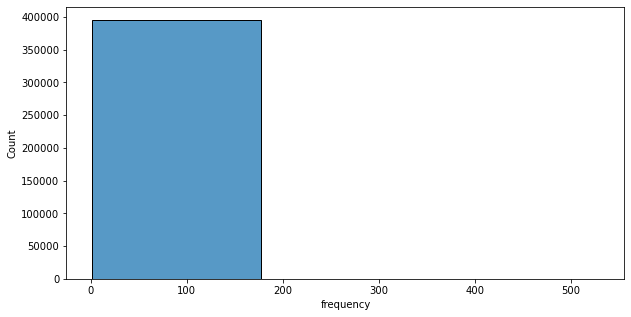

In [37]:
plt.figure(figsize = (10,5))
sns.histplot(data=df_clustering, x='frequency', bins=3)
plt.show()

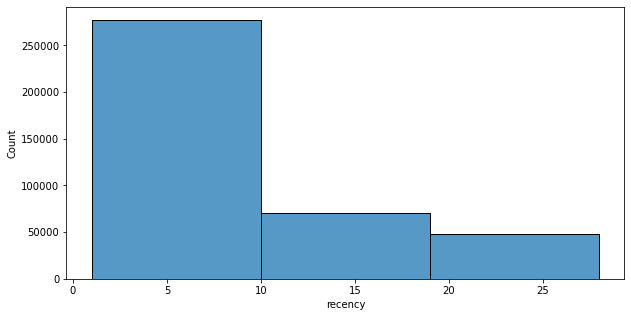

In [38]:
plt.figure(figsize = (10,5))
sns.histplot(data=df_clustering, x='recency', bins=3)
plt.show()

## Get recency and frequency groups

In [39]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_clustering[['recency']])
df_clustering['recencyCluster'] = kmeans.predict(df_clustering[['recency']])
df_clustering = order_cluster('recencyCluster','recency', df_clustering, False)

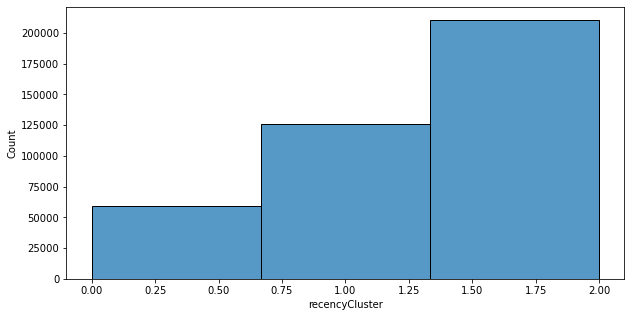

In [40]:
plt.figure(figsize = (10,5))
sns.histplot(data=df_clustering, x='recencyCluster', bins=3)
plt.show()

In [41]:
df_clustering[df_clustering['recencyCluster'] == 2].head()

uid        date  recency  frequency  \
185051  00fe8b718af04a9d95a3c43b050f5f79  2021-01-28        1         56   
185052  0150f3f8b25e419cb676711ab596c2a0  2021-01-27        2         21   
185053  01ea2f98880540a4a29566328790061d  2021-01-28        1         45   
185054  023dbd1500a14163aaa1c81bff21738e  2021-01-28        1         10   
185055  02515f1dff5b4ec793d064f000e072e1  2021-01-28        1        184   

        days  recencyCluster  
185051    14               2  
185052    11               2  
185053    20               2  
185054     8               2  
185055    19               2

In [42]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_clustering[['frequency']])
df_clustering['frequencyCluster'] = kmeans.predict(df_clustering[['frequency']])
df_clustering = order_cluster('frequencyCluster','frequency', df_clustering, False)

In [43]:
ey = np.array(df_clustering['frequency'])
qt = QuantileTransformer(output_distribution='normal')
df_clustering['procFrequency'] = qt.fit_transform(ey.reshape(-1, 1))
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_clustering[['procFrequency']])
df_clustering['frequencyCluster'] = kmeans.predict(df_clustering[['procFrequency']])
df_clustering = order_cluster('frequencyCluster','frequency', df_clustering, False)

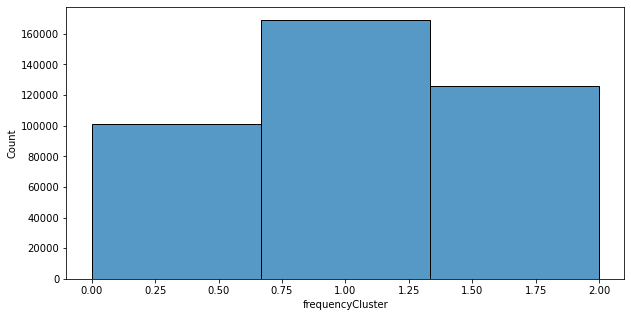

In [44]:
plt.figure(figsize = (10,5))
sns.histplot(data=df_clustering, x='frequencyCluster', bins=3)
plt.show()

In [45]:
df_clustering[df_clustering['frequencyCluster'] == 2].head()

uid        date  recency  frequency  \
100879  0172669e63654f948ddc3562e6ebb4d8  2021-01-01       28          1   
100880  04e0cdb15d5d4db8a2bc08961ad5e371  2021-01-04       25          1   
100881  0882a5f82b014133871ae50e81c09e22  2021-01-01       28          1   
100882  1658fc8f7abf41f880a4eeeff448cc2f  2021-01-01       28          1   
100883  230305894d7040d39ab6a1d3dfbee60e  2021-01-01       28          1   

        days  recencyCluster  procFrequency  frequencyCluster  
100879     1               0      -5.199338                 2  
100880     1               0      -5.199338                 2  
100881     1               0      -5.199338                 2  
100882     1               0      -5.199338                 2  
100883     1               0      -5.199338                 2

In [46]:
df_clustering['rf'] = df_clustering['recencyCluster'].astype(str) + df_clustering['frequencyCluster'].astype(str)
df_clustering.head()

uid        date  recency  frequency  days  \
0  0072c93fcc4742a58aa1d15e803480b0  2021-01-03       26         18     3   
1  0a22699daa424a268f18bd9cdcc66a42  2021-01-11       18         13     8   
2  0d86fbbcdfac47a2888ca8bfefacc703  2021-01-08       21         15     5   
3  145b49fe689c4a3d8bae89494e3b1d13  2021-01-08       21         17     5   
4  0184c9caee5b4da685159141e0eb84d6  2021-01-04       25         12     3   

   recencyCluster  procFrequency  frequencyCluster  rf  
0               0       1.149742                 0  00  
1               0       0.926176                 0  00  
2               0       1.025123                 0  00  
3               0       1.111702                 0  00  
4               0       0.873515                 0  00

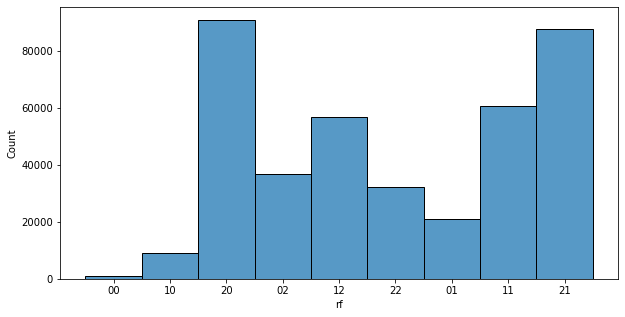

In [47]:
plt.figure(figsize = (10,5))
sns.histplot(data=df_clustering, x='rf', bins=9)
plt.show()

In [48]:
df_clustering['segment'] = df_clustering['rf'].apply(lambda x: rf_segment[x])
df_clustering.head()

uid        date  recency  frequency  days  \
0  0072c93fcc4742a58aa1d15e803480b0  2021-01-03       26         18     3   
1  0a22699daa424a268f18bd9cdcc66a42  2021-01-11       18         13     8   
2  0d86fbbcdfac47a2888ca8bfefacc703  2021-01-08       21         15     5   
3  145b49fe689c4a3d8bae89494e3b1d13  2021-01-08       21         17     5   
4  0184c9caee5b4da685159141e0eb84d6  2021-01-04       25         12     3   

   recencyCluster  procFrequency  frequencyCluster  rf   segment  
0               0       1.149742                 0  00  reconnus  
1               0       0.926176                 0  00  reconnus  
2               0       1.025123                 0  00  reconnus  
3               0       1.111702                 0  00  reconnus  
4               0       0.873515                 0  00  reconnus

In [49]:
df = df.merge(df_clustering[['uid','recencyCluster','frequencyCluster','rf','segment']], how='left',on='uid')

In [50]:
df.head()

uid        date  recency  frequency  days  \
0  0072c93fcc4742a58aa1d15e803480b0  2021-01-03       26         18     3   
1  009fc6f8613c4a29b40c40fa9ca6fbe3  2021-01-22        7          3     2   
2  00d276777288420e91634626065a7f70  2021-01-19       10          4     2   
3  00fe8b718af04a9d95a3c43b050f5f79  2021-01-28        1         56    14   
4  0150f3f8b25e419cb676711ab596c2a0  2021-01-27        2         21    11   

   recencyCluster  frequencyCluster  rf   segment  
0               0                 0  00  reconnus  
1               1                 1  11  reconnus  
2               1                 1  11  reconnus  
3               2                 0  20   fidèles  
4               2                 0  20   fidèles

In [51]:
df['segment'] = df['segment'].apply(lambda x: x if x == x else 'outliers')

In [52]:
df_clustering = df_clustering.merge(df_users, on='uid',how='left')
df_clustering.head()

uid        date  recency  frequency  days  \
0  0072c93fcc4742a58aa1d15e803480b0  2021-01-03       26         18     3   
1  0a22699daa424a268f18bd9cdcc66a42  2021-01-11       18         13     8   
2  0d86fbbcdfac47a2888ca8bfefacc703  2021-01-08       21         15     5   
3  145b49fe689c4a3d8bae89494e3b1d13  2021-01-08       21         17     5   
4  0184c9caee5b4da685159141e0eb84d6  2021-01-04       25         12     3   

   recencyCluster  procFrequency  frequencyCluster  rf   segment  \
0               0       1.149742                 0  00  reconnus   
1               0       0.926176                 0  00  reconnus   
2               0       1.025123                 0  00  reconnus   
3               0       1.111702                 0  00  reconnus   
4               0       0.873515                 0  00  reconnus   

   birth_deceny gender  
0           NaN      f  
1           NaN      m  
2           NaN      m  
3          55.0      m  
4          55.0      f

## Export

In [53]:
df_summary = df[['recency','frequency', 'segment']]
df_update = df_summary[df_summary['segment'] == 'outliers']
avg_frequency = np.average(df_update['frequency'])
avg_recency = np.average(df_update['recency'])
df_update['frequency'] = limit_frequency if avg_frequency > limit_frequency else avg_frequency
df_update['recency'] = avg_recency 
df_summary.update(df_update)
df_summary['recency'] = df_summary['recency'].apply(lambda x: 3 * round(x/3))
df_summary['frequency'] = df_summary['frequency'].apply(lambda x: 60 * round(x/60))
df_summary = df_summary.groupby(['recency','frequency','segment']).size().reset_index().rename(columns={0:'utilisateurs'})
df_summary.head()

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

recency  frequency       segment  utilisateurs
0        0          0       fidèles         31333
1        0          0  occasionnels          5471
2        0          0      reconnus         17716
3        0         60       fidèles         17005
4        0        120       fidèles          1607

### Metadata

In [54]:
with open('output/{}_rf_segments_summary.json'.format(quarter), '+w') as file:
    file.write('{{ {}, "summary": {}, "sociodemo" : {} }}'.format(','.join(['"{}": {}'.format(name,json.dumps(df[df['rf'].isin(seg['values'])][['frequency','recency','days']].describe().to_dict(orient='dict'))) for name, seg in segments.items() if 'values' in seg]), json.dumps(df_clustering.groupby(['recencyCluster','frequencyCluster','segment']).size().reset_index().rename(columns={0:'users'}).to_dict(orient='records')), json.dumps(df_clustering.groupby(['segment','gender','birth_deceny']).size().reset_index().rename(columns={0:'users'}).to_dict(orient='records'))))

---

## Global Network 

In [55]:
df_consumption_global = df_media_consummed.merge(df_clustering, on='uid', how='inner')
#df_consumption_global = df_media_consummed.merge(df, on='uid', how='inner')
df_consumption_global.head()

uid contenttypestat          labelstat  \
0  00022ee722684cf2beaff4f9b9751742           sport                WRC   
1  00022ee722684cf2beaff4f9b9751742   entertainment  Le 8-9 - Zap télé   
2  00035927d9e942ffa075c507d71bfaa5           sport                WRC   
3  00047e98b4f1498abcec6b23806de0e7       lifestyle    Bientôt à table   
4  00047e98b4f1498abcec6b23806de0e7     information      Investigation   

   consummed  rnum_cnt        date  recency  frequency  days  recencyCluster  \
0          8         1  2021-01-22        7          3     2               1   
1          2         2  2021-01-22        7          3     2               1   
2          1         1  2021-01-24        5          1     1               2   
3          1         1  2021-01-28        1          2     2               2   
4          1         2  2021-01-28        1          2     2               2   

   procFrequency  frequencyCluster  rf       segment  birth_deceny gender  
0       0.012546                 1  11      reconnus           NaN      m  
1       0.012546                 1  11      reconnus           NaN      m  
2      -5.199338                 2  22  occasionnels           NaN    NaN  
3      -0.282216                 1  21      reconnus          65.0    NaN  
4      -0.282216                 1  21      reconnus          65.0    NaN

In [ ]:
#df_consumption_global = df_consumption_global[['uid','frequency','rf','contenttypestat','date','labelstat','consummed']]
#df_consumption_global.head()

## Segment Network

In [ ]:
df_consumption_segment = df_consumption_global[df_consumption_global['rf'].isin(segment['values'])]
df_consumption_segment.shape

In [ ]:
#df_consumption_segment = df_consumption_segment[['uid','frequency','contenttypestat','date','labelstat','consummed']]

In [ ]:
df_consumption_segment.head()

In [ ]:
df_consumption_segment['labelstat'].unique().shape

In [ ]:
df_labelstats = df_consumption_segment.copy()
df_labelstats = df_labelstats[['labelstat','contenttypestat']].groupby(['labelstat','contenttypestat']).size().reset_index().rename(columns={0:'consummed'}).sort_values('consummed', ascending=False)
df_labelstats.head()

In [ ]:
df_labelstats['percentage'] = df_labelstats['consummed']/np.sum(df_labelstats['consummed'])
df_labelstats.head()

In [ ]:
df_labelstats['cumsum'] = df_labelstats['percentage'].cumsum()
df_labelstats.head(50)

In [ ]:
df_labelstats = df_labelstats[df_labelstats['cumsum'] <= 0.9]

In [ ]:
labelstat_90 = df_labelstats['labelstat']
labelstat_90

In [ ]:
df_consumption_segment_media_90 = df_consumption_segment[df_consumption_segment['labelstat'].isin(labelstat_90)]

In [ ]:
df_nodes = df_labelstats.copy()
df_nodes = df_nodes[['labelstat', 'contenttypestat', 'consummed']].rename(columns={'labelstat':'name', 'contenttypestat': 'grp', 'consummed':'n'})
df_nodes['id'] = df_nodes['name']
df_nodes['sociodemo'] = df_nodes['name'].apply(lambda x: df_consumption_segment[df_consumption_segment['labelstat'] == x].groupby(['gender','birth_deceny']).size().reset_index().rename(columns={0:'users'}).to_dict(orient='records'))
df_nodes.head()

### Nodes

In [ ]:
df_nodes.to_dict(orient='records')

---

In [ ]:
df_consumption_segment_media_90 = df_consumption_segment_media_90.sort_values(['uid','consummed'], ascending=False)

In [ ]:
df_links = df_consumption_segment_media_90.groupby('uid')['labelstat'].apply(lambda x: '{{ "source":"{}", "target":"{}" }}'.format(list(x)[0], list(x)[1] if len(list(x)) > 1 else '')).reset_index()
df_links.head()

In [ ]:
df_links['source'] = df_links['labelstat'].apply(lambda x : json.loads(x)['source'])
df_links['target'] = df_links['labelstat'].apply(lambda x : json.loads(x)['target'])
df_links.head()

In [ ]:
df_links = df_links[['source','target','uid']].groupby(['source','target']).count().reset_index().rename(columns={'uid':'value'})
df_links.head()

In [ ]:
df_links = df_links[df_links['target'] != '']
df_links.head()

In [ ]:
df_links = df_links[df_links['source'] != df_links['target']]
df_links.head()

### Links

In [ ]:
df_links.to_dict(orient='records')

---

In [ ]:
with open('output/{}_conso_network_{}.json'.format(quarter, segment['name']), '+w') as file:
    file.write('{{ "nodes":{}, "links": {}, "attributes": "" }}'.format(json.dumps(df_nodes.to_dict(orient='records')),json.dumps(df_links.to_dict(orient='records'))))